In [77]:
from numpy import linalg as LA
import numpy as np
from numpy import *
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

QUIET    = 0;
MAX_ITER = 1500;
ABSTOL   = 1e-6;
RELTOL   = 1e-5;
MU = 10
tau_incr = 2
tau_decr = 2

#class for storing error norms for graphs later:
class record:
    r_norm = []
    s_norm1 = []
    s_norm2 = []
    objval_x = []
    objval_z = []
    eps_pri = []
    eps_dual = []
    ztilda_record = []
    xyratio = []
    sigma_record = []
    v_record = []
    utilda_inc_norm = []
    utilda_record = []
    uzproduct = []
    
    def __init__(self, n):
        self.r_norm = np.zeros(n)
        self.s_norm1 = np.zeros(n)
        self.s_norm2 = np.zeros(n)
        self.objval_x = np.zeros(n)
        self.objval_z = np.zeros(n)
        self.eps_pri = np.zeros(n)
        self.eps_dual = np.zeros(n)
        self.ztilda_record = np.zeros((n,2))
        self.xyratio = np.zeros(n)
        self.sigma_record = np.zeros((n,2))
        self.utilda_inc_norm = np.zeros(n)
        self.utilda_record = np.zeros((n,2))
        self.uzproduct = np.zeros(n)
        self.v_record = np.zeros((n,2))
        
        
def projection_2D(x, mu = 1):
    if LA.norm(x) == 0:
        return x
    if abs(x[0]) <= mu*x[1]:
        #inside the cone
        return x
    elif abs(x[0]) <= -x[1]/mu:
        #inside polar cone
        return np.zeros(2)
    else:
        #project to the xyplane:
        t_hat = x[0]
        #normalize:
        t_hat = t_hat/LA.norm(t_hat)
        unit = np.append(mu*t_hat, 1)
        unit= unit/np.sqrt(1+mu**2)
        #now project to the ray:
        return np.inner(unit, x)*unit   

    

#qp with ADMM customized for physical problem
# M: mass matrix, J: geomety matrix to get relative velocity 
# R: should be passed into as a vector since it is diagonal 
def quadprog_conic(vn, sigman, M, J, R, vstar, vhat, rho, alpha, mustartilda = 1, mu = 1):
    n1 = J.shape[0]
    n2 = R.shape[0]
    n3 = M.shape[0]
    v = vn
    sigma = projection_2D(-1/R*(J.dot(v) -vhat), mu)
    #sigma = np.zeros(n2)
    z = J.dot(v) - vhat + R*sigma
    ztilda = 1/(np.sqrt(R))*z
    utilda = -np.sqrt(R)*sigma/rho
    num_iter = 0
    history = record(MAX_ITER)
    rho_new = rho
    L = zeros((n3,n3))
    
    #print('initial check')
    #print(LA.norm(R*(sigma+rho*(np.sqrt(R)*utilda))))
    
    for k in range(MAX_ITER):
        if rho_new != rho or k == 0:
            rho = rho_new
            L = LA.cholesky(M + rho/(1+rho)*np.matmul(np.transpose(J), np.matmul(np.diag(1/R), J)))
            rsigma = rho*np.sqrt(R)*(ztilda - utilda + 1/(np.sqrt(R))*vhat)
            rv = np.transpose(J).dot((1/R*rsigma)) + M.dot(vstar)
            rhs = rv - rho/(1+rho)*np.transpose(J).dot(1/R*rsigma)
            v = LA.solve(np.transpose(L), rhs)
            v = LA.solve(L, v)
            sigma = 1/(1+rho)*(1/R* (rsigma - rho*J.dot(v)))
        else:
            rsigma = rho*np.sqrt(R)*(ztilda - utilda + 1/(np.sqrt(R))*vhat)
            rv = np.transpose(J).dot((1/R*rsigma)) + M.dot(vstar)
            rhs = rv - rho/(1+rho)*np.transpose(J).dot(1/R*rsigma)
            v = LA.solve(np.transpose(L), rhs)
            v = LA.solve(L, v)
            sigma = 1/(1+rho)*(1/R* (rsigma - rho*J.dot(v)))
        
        #z-update with relaxation
        ztildaold = ztilda
        #x_hat = alpha*x + (1-alpha)*zold
        
        #projection to the cone:
        #z = np.minimum(ub, np.maximum(lb, x_hat+u))
        #3D projection (uncomment for conic constraints and comment line above for conic constraints):
        ztilda = projection_2D(1/(np.sqrt(R))*J.dot(v)+np.sqrt(R)*sigma + utilda - 1/(np.sqrt(R))*vhat, mustartilda)
        
        utilda = utilda + 1/(np.sqrt(R))*J.dot(v)+np.sqrt(R)*sigma - ztilda - 1/(np.sqrt(R))*vhat
        
        #three stopping criteria:
        #1. check r:
        
        history.r_norm[k] = LA.norm(np.sqrt(R)*(1/(np.sqrt(R))*J.dot(v)+np.sqrt(R)*sigma - ztilda - 1/(np.sqrt(R))*vhat))
        history.s_norm1[k] = LA.norm(R*sigma+rho*(np.sqrt(R)*utilda))
        tauc = np.transpose(J).dot(sigma)
        P = M.dot(v)
        rm = M.dot(v - vstar)-tauc
        history.s_norm2[k] = LA.norm(rm)/np.maximum(LA.norm(P), LA.norm(tauc))
        history.xyratio[k] = abs(sigma[0]/sigma[1])
        history.sigma_record[k,:] = sigma

        history.eps_pri[k] = ABSTOL + RELTOL*np.maximum(LA.norm(J.dot(v)), LA.norm(vhat))
        #update rho if two norms are very different:
        #if history.r_norm[k] > MU*history.s_norm[k] and rho < 10000:
            #rho_new = rho*tau_incr
            #utilda = utilda/tau_incr
        #if history.s_norm[k] > MU*history.r_norm[k] and rho < 10000:
            #rho_new = rho/tau_decr
            #utilda = utilda*tau_decr
        if k > 100:
            print(history.r_norm[k])
            print(history.s_norm1[k])
            print(history.s_norm2[k])
            print(history.xyratio[k])
        #stopping criterion:
        if (history.r_norm[k] < history.eps_pri[k] and history.s_norm1[k] < history.eps_pri[k] and history.s_norm2[k] < ABSTOL):#and history.xyratio[k] < mu):
            #print('hit here')
            #print('xyratio:')
            #print(history.xyratio[k])
            #print('mu')
            #print(mu)
            num_iter = k+1
            break
    if num_iter == 0:
        print('used all iterations with rho:')
        print(rho)
    
    return v,sigma, history, num_iter


def quadprog_conic_general(vn, sigman, M, J, R, D, vstar, vhat, rho, alpha, mustartilda = 1, mu = 1, verbose = False):
    n1 = J.shape[0]
    n2 = R.shape[0]
    n3 = M.shape[0]
    v = vn
    mutilda = np.sqrt(R[0]/R[1])*mu
    y = -1/R*(J.dot(v)-vhat)
    ytilda = np.sqrt(R)*y
    sigmatilda = projection_2D(ytilda, mutilda)  # TODO: WRONG: NEED TO PROJECT WITH R NORM, CHECK THE NOTES
    sigma = 1/np.sqrt(R) * sigmatilda
    Rt = R[0]
    Rn = R[1]
    yr = abs(y[0])
    yn = y[1]
    gamman = 1/(1+mutilda**2)*(yn+mu*Rt/Rn*yr)
    if verbose:
        print("y", y)
        print("sigmatilda", sigmatilda)
        print("sigma", sigma)
        print("mutilda:", mutilda)
        print("v", v)
        print("vhat", vhat)
        print("R", R)
        print("gamman", gamman)
    #sigma = np.zeros(n2)
    #sigma = projection_2D(-1/D*(J.dot(v) -vhat), mu)
    z = J.dot(v) - vhat + R*sigma
    ztilda = 1/(np.sqrt(D))*z
    utilda = -np.sqrt(D)*sigma/rho
    num_iter = 0
    history = record(MAX_ITER)
    rho_new = rho
    L = zeros((n3,n3))
    
    history.utilda_record[0, :] = utilda
    
    #print('initial check')
    #print(LA.norm(R*(sigma+rho*(np.sqrt(R)*utilda))))
    
    B = M+rho*np.matmul(np.transpose(J), np.matmul(np.diag(1/D), J))
    C = rho*np.matmul(np.diag(R*1/D), J)
    E = R + rho*R*R*1/D #E is still vector!!
    
    for k in range(MAX_ITER):
        if rho_new != rho or k == 0:
            rho = rho_new
            L = LA.cholesky(B - np.matmul(np.transpose(C), np.matmul(np.diag(1/E), C)))
            rsigma = rho*R*1/(np.sqrt(D))*(ztilda - utilda + 1/(np.sqrt(D))*vhat)
            rv = np.transpose(J).dot((1/R*rsigma)) + M.dot(vstar)
            rhs = rv - np.transpose(C).dot(1/E*rsigma)
            v = LA.solve(np.transpose(L), rhs)
            v = LA.solve(L, v)
            sigma = 1/E*(rsigma - C.dot(v))
        else:
            rsigma = rho*R*1/(np.sqrt(D))*(ztilda - utilda + 1/(np.sqrt(D))*vhat)
            rv = np.transpose(J).dot((1/R*rsigma)) + M.dot(vstar)
            rhs = rv - np.transpose(C).dot(1/E*rsigma)
            v = LA.solve(np.transpose(L), rhs)
            v = LA.solve(L, v)
            sigma = 1/E*(rsigma - C.dot(v))
        
        #z-update with relaxation
        ztildaold = ztilda
        #x_hat = alpha*x + (1-alpha)*zold
        
        #projection to the cone:
        #z = np.minimum(ub, np.maximum(lb, x_hat+u))
        #3D projection (uncomment for conic constraints and comment line above for conic constraints):
        ztilda = projection_2D(1/(np.sqrt(D))*J.dot(v)+ 1/(np.sqrt(D))*R*sigma + utilda - 1/(np.sqrt(D))*vhat, mustartilda)
        
        utilda = utilda + 1/(np.sqrt(D))*J.dot(v)+ 1/(np.sqrt(D))*R*sigma - ztilda - 1/(np.sqrt(D))*vhat
        
        history.utilda_inc_norm[k] = LA.norm(1/(np.sqrt(D))*J.dot(v)+ 1/(np.sqrt(D))*R*sigma - ztilda - 1/(np.sqrt(D))*vhat)
        history.v_record[k, :] = v
        history.utilda_record[k, :] = utilda
        history.ztilda_record[k, :] = ztilda
        history.uzproduct[k] = np.inner(utilda,ztilda)
        
        #three stopping criteria:
        #1. check r:
        
        history.r_norm[k] = LA.norm(np.sqrt(D)*(1/(np.sqrt(D))*J.dot(v)+1/(np.sqrt(D))*R*sigma - ztilda - 1/(np.sqrt(D))*vhat))
        history.s_norm1[k] = LA.norm(R*sigma+rho*R*(1/np.sqrt(D)*utilda))
        tauc = np.transpose(J).dot(sigma)
        P = M.dot(v)
        rm = M.dot(v - vstar)-tauc
        history.s_norm2[k] = LA.norm(rm)/np.maximum(LA.norm(P), LA.norm(tauc))
        history.xyratio[k] = abs(sigma[0]/sigma[1])
        history.sigma_record[k,:] = sigma

        history.eps_pri[k] = ABSTOL + RELTOL*np.maximum(LA.norm(J.dot(v)), LA.norm(vhat))
        #update rho if two norms are very different:
        #if history.r_norm[k] > MU*history.s_norm[k] and rho < 10000:
            #rho_new = rho*tau_incr
            #utilda = utilda/tau_incr
        #if history.s_norm[k] > MU*history.r_norm[k] and rho < 10000:
            #rho_new = rho/tau_decr
            #utilda = utilda*tau_decr
        #if k > 100:
            #print(history.r_norm[k])
            #print(history.s_norm1[k])
            #print(history.s_norm2[k])
            #print(history.xyratio[k])
        #stopping criterion:
        if (history.r_norm[k] < history.eps_pri[k] and history.s_norm1[k] < history.eps_pri[k] and history.s_norm2[k] < ABSTOL):#and history.xyratio[k] < mu):
            #print('hit here')
            #print('xyratio:')
            #print(history.xyratio[k])
            #print('mu')
            #print(mu)
            num_iter = k+1
            break
    if num_iter == 0:
        print('used all iterations with rho:')
        print(rho)
        num_iter = MAX_ITER
    
    return v,sigma, history, num_iter



In [80]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from numpy.linalg import inv
from matplotlib.pyplot import figure

#Dropping Particel Code:

def dropping_particle(time = 2, dt = 0.1, tau_d = 0, pos_start = np.array([1,0]), vel_start = np.array([0,0]), test = False):
    
    rho = 1
    alpha = 1
    #tau_d = 1
    m = 1
    mu = 0.5
    g = np.array([0, -10])
    F = np.array([6,0]) #applied force in Newtons
    epsilon = 0.001
    M = m*np.identity(2)
    J = np.identity(2)
    #dt = 0.01
    k = 1000
    Rn = 1/(dt*(dt+tau_d)*k)
    Rt = epsilon*Rn
    R = np.array([Rt, Rn])

    #quantities needed for optimization:
    q0 = pos_start
    v0 = vel_start
    sigma0 = np.array([0, 0])

    vhat = np.array([0, -q0[1]/(dt+tau_d)])

    #time = 5
    steps = int(time/dt)

    q = q0
    v = v0
    sigma = sigma0
    positions_record = np.zeros((steps, 2))
    velocities_record = np.zeros((steps,2))
    force_record = np.zeros((steps,2))
    num_iters = np.zeros(steps)
    epsilon_record = np.zeros(steps)
    r_norm_record = np.zeros(steps)
    s_norm1_record = np.zeros(steps)
    verbose = [True, True]
    #if test:
        #steps = 1
    for i in range(steps):

        vhat[1] = -q[1]/(dt+tau_d)
        vstar = v + dt*g + F/m*dt
        vn = v
        sigman = sigma
        #v,sigma, history, num_iter = quadprog_conic(vn, sigman, M, J, R, vstar, vhat, rho, alpha, np.sqrt(Rn/Rt)*1/mu, mu)
        
        WM = np.matmul(np.transpose(J), np.matmul(inv(M), J))
        D = diag(WM)
        v,sigma, history, num_iter = quadprog_conic_general(vn, sigman, M, J, R, D, vstar, vhat, rho, alpha, np.sqrt(D[1]/D[0])*1/mu, mu)
        
        
        #D = R 
        #v,sigma, history, num_iter = quadprog_conic_general(vn, sigman, M, J, R, D, vstar, vhat, rho, alpha, np.sqrt(D[1]/D[0])*1/mu, mu)
        
        r_norm_record[i] = history.r_norm[num_iter-1]
        s_norm1_record[i] = history.s_norm1[num_iter-1]
        
        
        if test and i*dt == 1: 
            print("Data from D as Dallassus: ")
            
            v,sigma, history, num_iter = quadprog_conic_general(vn, sigman, M, J, R, D, vstar, vhat, rho, alpha, np.sqrt(D[1]/D[0])*1/mu, mu, True)
            figure()
            #t = np.arange(0, num_iter, 1)    

            print(num_iter)
            plt.plot( history.xyratio[0:num_iter])
            plt.yscale("log")
            plt.title('xyratio')
            plt.show()
            print(history.xyratio[0:40])
            
            plt.plot( history.sigma_record[0:num_iter, 0]/dt)
            plt.title('x_dir force vs itera')
            plt.show()
            plt.plot( history.sigma_record[0:num_iter, 1]/dt)
            plt.title('y_dir force vs itera')
            plt.show()
            
            print('starting forces: ', history.sigma_record[0:10, :]/dt)
            
            plt.plot( history.utilda_inc_norm[0:num_iter])
            plt.title('inc norm of utilda')
            plt.show()
            
            print('inc norm',history.utilda_inc_norm[0:num_iter] )

            plt.plot( np.absolute(history.sigma_record[0:num_iter, 0]))
            plt.yscale("log")
            plt.title('xforce')
            plt.show()
            plt.plot( history.sigma_record[0:num_iter, 1])
            plt.yscale("log")
            plt.title('yforce')
            plt.show()
            print('force final')
            print(history.sigma_record[num_iter-1, :])
            plt.plot(history.r_norm[0:num_iter])
            plt.yscale("log")
            plt.title("r_norm")
            plt.show()
            plt.plot(history.s_norm1[0:num_iter])
            plt.yscale("log")
            plt.title("snorm1")
            plt.show()
            
            plt.plot(history.r_norm[0:num_iter])
            plt.plot(history.s_norm1[0:num_iter])
            plt.legend(["r norm", "s norm1"])
            plt.yscale("log")
            plt.show()
            print("starting r norms:", history.r_norm[0:15])
            print("starting s norms:", history.s_norm1[0:15])

            
            plt.plot(history.s_norm2[0:num_iter])
            plt.yscale("log")
            plt.title("snorm2")
            plt.show()
                                  
            plt.plot(history.uzproduct[0:num_iter])
            plt.title("uzproduct")
            plt.show()
            
            plt.plot(np.absolute(history.utilda_record[0:num_iter, 0]/history.utilda_record[0:num_iter, 1]))
            plt.title("utilda slope")
            plt.show()
            print("utilda slope", np.absolute(history.utilda_record[0:num_iter, 0]/history.utilda_record[0:num_iter, 1]))
            
            plt.plot(history.utilda_record[0:num_iter, 0])
            plt.title("utilda x coord")
            plt.show()
            plt.plot(history.utilda_record[0:num_iter, 1])
            plt.title("utilda y coord")
            plt.show()
            
            print('starting forces:', history.sigma_record[0:20, :]/dt)
            
            
            D = R 
            v,sigma, history, num_iter = quadprog_conic_general(vn, sigman, M, J, R, D, vstar, vhat, rho, alpha, np.sqrt(D[1]/D[0])*1/mu, mu)
            print("Data from D as R: ")
            print('mustartilda:', np.sqrt(D[1]/D[0])*1/mu)
            figure()
            #t = np.arange(0, num_iter, 1)    

            print(num_iter)
            plt.plot( history.xyratio[0:num_iter])
            plt.yscale("log")
            plt.title('xyratio')
            plt.show()
            print(history.xyratio[0:40])
            
            plt.plot( history.sigma_record[0:num_iter, 0]/dt)
            plt.title('x_dir force vs itera')
            plt.show()
            plt.plot( history.sigma_record[0:num_iter, 1]/dt)
            plt.title('y_dir force vs itera')
            plt.show()
            
            print('starting forces: ', history.sigma_record[0:10, :]/dt)
            
            plt.plot( history.utilda_inc_norm[0:num_iter])
            plt.title('inc norm of utilda')
            plt.show()
            
            print('inc norm',history.utilda_inc_norm[0:num_iter] )

            plt.plot( np.absolute(history.sigma_record[0:num_iter, 0]))
            plt.yscale("log")
            plt.title('xforce')
            plt.show()
            plt.plot( history.sigma_record[0:num_iter, 1])
            plt.yscale("log")
            plt.title('yforce')
            plt.show()
            print('force final')
            print(history.sigma_record[num_iter-1, :])
            plt.plot(history.r_norm[0:num_iter])
            plt.yscale("log")
            plt.title("r_norm")
            plt.show()
            plt.plot(history.s_norm1[0:num_iter])
            plt.yscale("log")
            plt.title("snorm1")
            plt.show()
            
            plt.plot(history.r_norm[0:num_iter])
            plt.plot(history.s_norm1[0:num_iter])
            plt.legend(["r norm", "s norm1"])
            plt.yscale("log")
            axes = plt.gca()
    
            axes.set_ylim([1e-5,10])
            plt.show()
        

            
            plt.plot(history.s_norm2[0:num_iter])
            plt.yscale("log")
            plt.title("snorm2")
            plt.show()
                                  
            plt.plot(history.uzproduct[0:num_iter])
            plt.title("uzproduct")
            plt.show()
            
            plt.plot(np.absolute(history.utilda_record[0:num_iter, 0]/history.utilda_record[0:num_iter, 1]))
            plt.title("utilda slope")
            plt.show()
            print("utilda slope", np.absolute(history.utilda_record[0:num_iter, 0]/history.utilda_record[0:num_iter, 1]))
            
            
            
            plt.plot(np.absolute(history.ztilda_record[0:num_iter, 1]/history.ztilda_record[0:num_iter, 0]))
            plt.title("ztilda slope")
            plt.show()
            print("ztilda slope", np.absolute(history.ztilda_record[0:num_iter, 1]/history.ztilda_record[0:num_iter, 0]))
            
            plt.plot(history.utilda_record[0:num_iter, 0])
            plt.title("utilda x coord")
            plt.show()
            plt.plot(history.utilda_record[0:num_iter, 1])
            plt.title("utilda y coord")
            plt.show()
            print('R', R)
            
            length = 30
            print("starting r norms:", history.r_norm[0:length])
            print("starting s norms:", history.s_norm1[0:length])
            print("starting utildas:", history.utilda_record[0:length, :])
            print("starting ys:", rho*1/np.sqrt(D) *history.utilda_record[0:length, :])
            print("starting ztildas:", history.ztilda_record[0:length, :])
            print("starting forces:", history.sigma_record[0:length, :]/dt)
            print("starting velocities:", history.v_record[0:length, :])
            
        tauc = np.transpose(J).dot(sigma)
        P = M.dot(v)
        rm = M.dot(v - vstar)-tauc
        epsilonmn = LA.norm(rm)/np.maximum(LA.norm(P), LA.norm(tauc))
        epsilon_record[i] = epsilonmn
        q = q + dt*v
        
        #print(numiter)
        positions_record[i, :] = q
        velocities_record[i, :] = v
        force_record[i, :] = sigma
        num_iters[i] = num_iter
        
        if v[0] < v0[0] and verbose[0] == True:
            print('velocity starts dropping at time')
            print(i*dt)
            verbose[0] = False
        
        if (v[0] < 1e-6) and verbose[1] == True:
            print('velocity drop to 0 at time')
            print(i*dt)
            verbose[1] = False
    t = np.arange(0, time, dt)    
    plt.plot(t, positions_record[:, 0])
    plt.title('positions on the x direction')
    plt.show()
    figure()
    t = np.arange(0, time, dt)    
    plt.plot(t, positions_record[:, 1])
    plt.title('positions on the y direction')
    plt.show()
    figure()
    plt.plot(t, velocities_record[:, 0])
    plt.title('velocities on the x direction')
    plt.show()
    figure()
    plt.plot(t, velocities_record[:, 1])
    plt.title('velocities on the y direction')
    plt.show()
    figure()
    plt.plot(t, force_record[:, 0]/dt)
    plt.title('force on the x direction')
    plt.show()
    figure()
    plt.plot(t, force_record[:, 1]/dt)
    plt.title('force on the y direction')
    plt.show()
    figure()
    plt.plot(t, force_record[:, 0]/force_record[:, 1])
    plt.title('force quotient x/y')
    plt.show()
    figure()
    plt.plot(t, epsilon_record)
    plt.title('epsilonmn')
    plt.show()
    figure()
    plt.plot(t, r_norm_record)
    plt.title('r_norm residual')
    plt.show()
    figure()
    plt.plot(t, s_norm1_record)
    plt.title('s_norm1 residual')
    plt.show()
    figure()
    plt.plot(t, num_iters)
    plt.title('Number of Iterations Taken')
    plt.show()
    #print(velocities_record[0, 1])
    print('x force at time end:')
    print(force_record[-5, 0])
    print('y force at time end:')
    print(force_record[-5,1])
    print('velovity at time 3', velocities_record[int(3/dt)])
    print('R', R)
    print(force_record[0,0]/force_record[0,1])
    print(num_iters[-2])
    print(tau_d)
    print(mu)
    print('lowest displacement on y: ', np.amin(positions_record[:, 1]) )        
        





Data from D as Dallassus: 
y [ -2.46744324e+03  -7.96044820e-01]
sigmatilda [-0.00437567  0.27674193]
sigma [-0.2187837   0.43756741]
mutilda: 0.0158113883008
v [ 0.9869773   0.02497371]
vhat [ 0.         -0.29344422]
R [ 0.0004  0.4   ]
gamman 0.437567409158
11


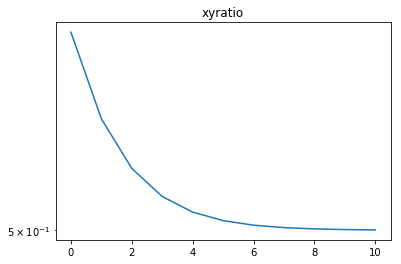

[ 0.55952194  0.53267177  0.51786819  0.50967884  0.50518852  0.50275489
  0.50145063  0.50075848  0.50039423  0.50020388  0.50010499  0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]


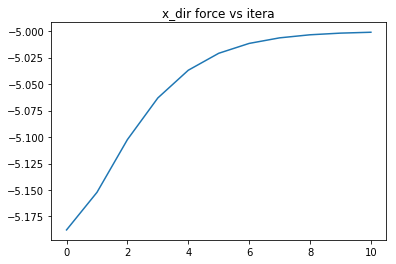

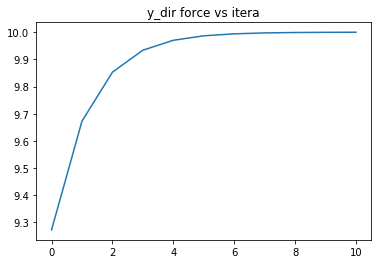

starting forces:  [[-5.18767465  9.27161977]
 [-5.15219021  9.67235452]
 [-5.1023935   9.85268753]
 [-5.0630684   9.9338407 ]
 [-5.03691253  9.97036224]
 [-5.02091189  9.98679869]
 [-5.01159596  9.99419615]
 [-5.00634576  9.99752563]
 [-5.00345403  9.99902425]
 [-5.00188813  9.99969882]]


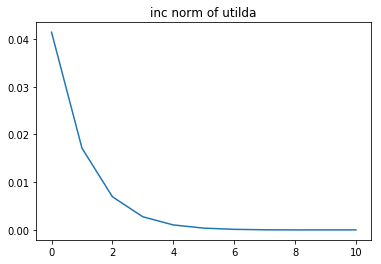

inc norm [  4.14241372e-02   1.71279467e-02   6.95124866e-03   2.74994417e-03
   1.04843040e-03   3.77274761e-04   1.22514104e-04   3.15007547e-05
   2.35927919e-06   4.84689543e-06   5.13573034e-06]


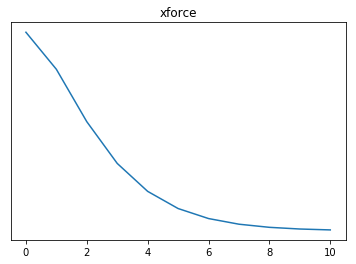

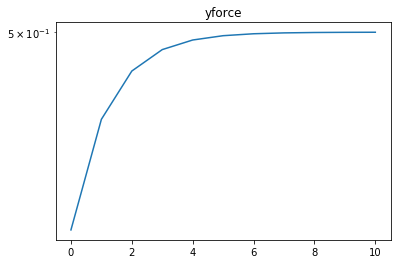

force final
[-0.25005256  0.50000012]


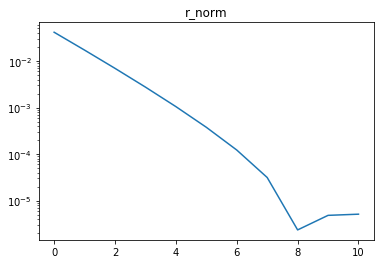

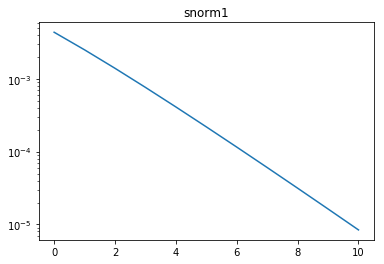

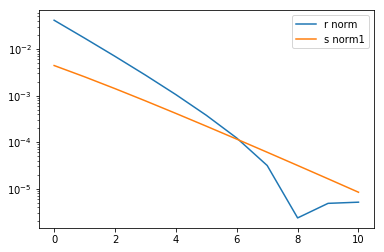

starting r norms: [  4.14241372e-02   1.71279467e-02   6.95124866e-03   2.74994417e-03
   1.04843040e-03   3.77274761e-04   1.22514104e-04   3.15007547e-05
   2.35927919e-06   4.84689543e-06   5.13573034e-06   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00]
starting s norms: [  4.41492690e-03   2.52810867e-03   1.40840070e-03   7.69185936e-04
   4.13852115e-04   2.20100837e-04   1.15983308e-04   6.06636439e-05
   3.15353440e-05   1.63098346e-05   8.39918571e-06   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00]


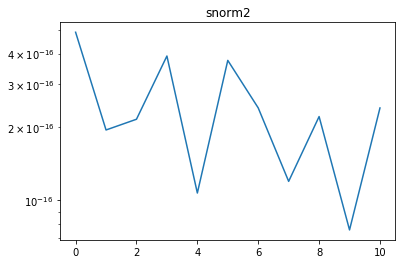

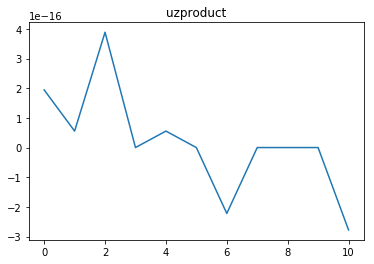

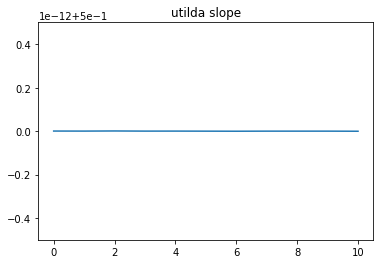

utilda slope [ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5]


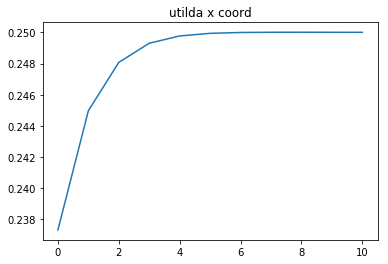

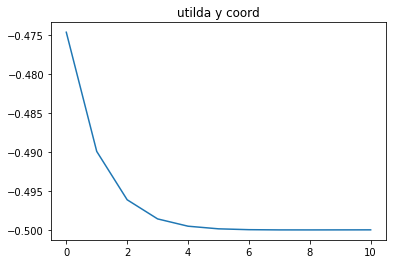

starting forces: [[ -5.18767465   9.27161977]
 [ -5.15219021   9.67235452]
 [ -5.1023935    9.85268753]
 [ -5.0630684    9.9338407 ]
 [ -5.03691253   9.97036224]
 [ -5.02091189   9.98679869]
 [ -5.01159596   9.99419615]
 [ -5.00634576   9.99752563]
 [ -5.00345403   9.99902425]
 [ -5.00188813   9.99969882]
 [ -5.00105113  10.00000248]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]]
used all iterations with rho:
1
Data from D as R: 
mustartilda: 63.2455532034
1500


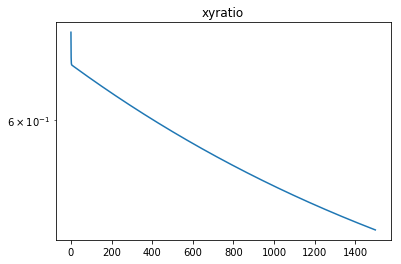

[ 0.63511634  0.62485982  0.62257925  0.62202844  0.62185988  0.62177617
  0.62171133  0.6216507   0.62159104  0.62153161  0.62147225  0.62141294
  0.62135365  0.6212944   0.62123518  0.62117599  0.62111683  0.62105769
  0.62099859  0.62093952  0.62088048  0.62082147  0.62076248  0.62070353
  0.62064461  0.62058571  0.62052685  0.62046802  0.62040921  0.62035044
  0.62029169  0.62023298  0.62017429  0.62011564  0.62005701  0.61999842
  0.61993985  0.61988131  0.6198228   0.61976433]


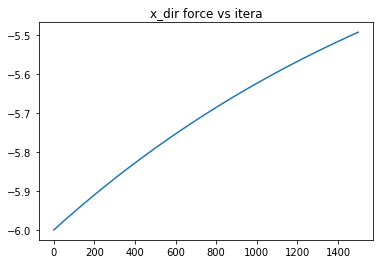

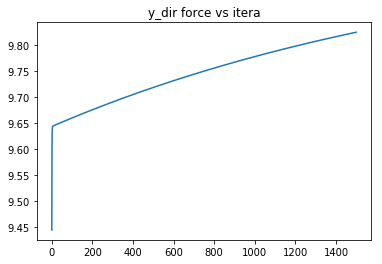

starting forces:  [[-5.99870158  9.44504364]
 [-5.9983304   9.59948171]
 [-5.99788232  9.6339258 ]
 [-5.99741733  9.64170926]
 [-5.99694875  9.64356913]
 [-5.99647955  9.64411282]
 [-5.99601038  9.64436402]
 [-5.9955414   9.64455017]
 [-5.99507262  9.6447218 ]
 [-5.99460406  9.64489015]]


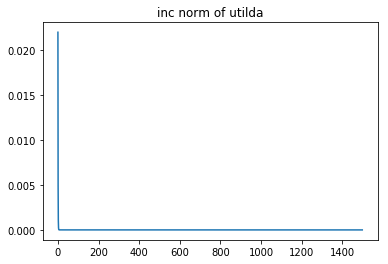

inc norm [  2.19594939e-02   4.88314436e-03   1.08907472e-03 ...,   2.62282588e-06
   2.62159069e-06   2.62035609e-06]


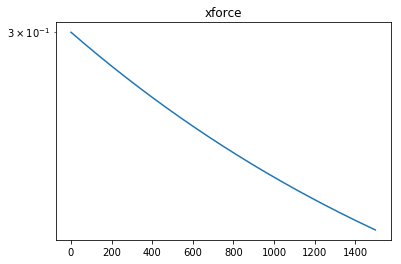

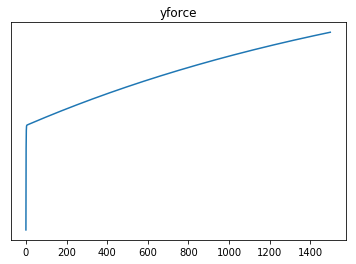

force final
[-0.27465247  0.49120564]


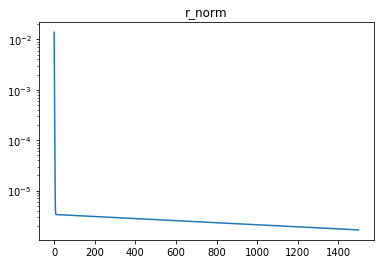

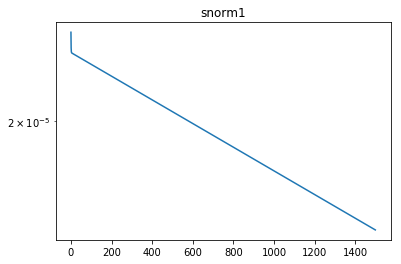

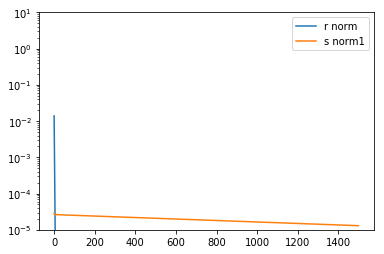

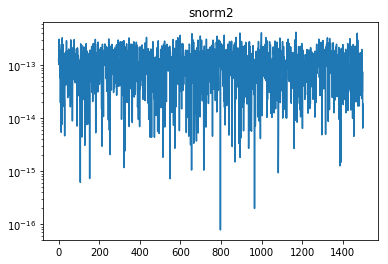

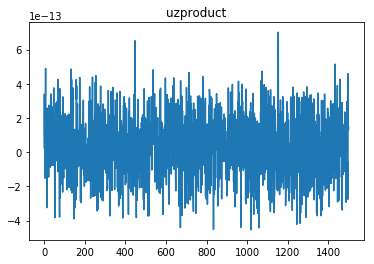

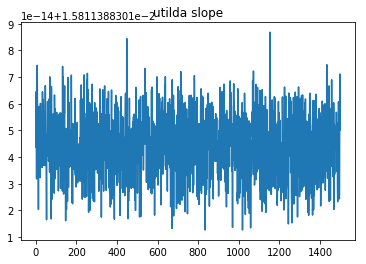

utilda slope [ 0.01581139  0.01581139  0.01581139 ...,  0.01581139  0.01581139
  0.01581139]


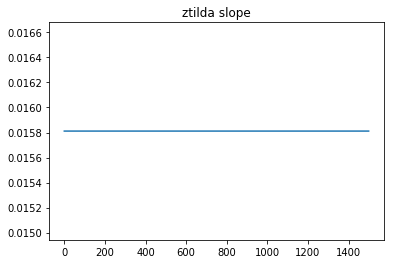

ztilda slope [ 0.01581139  0.01581139  0.01581139 ...,  0.01581139  0.01581139
  0.01581139]


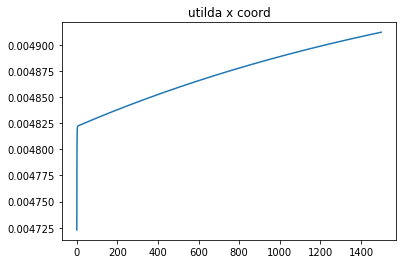

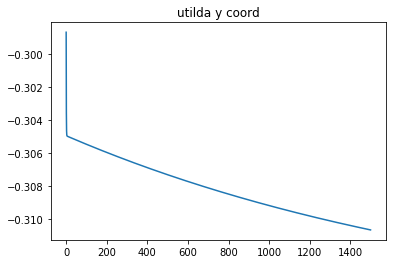

R [ 0.0004  0.4   ]
starting r norms: [  1.38866694e-02   3.08798608e-03   6.88705338e-04   1.55625684e-04
   3.71834343e-05   1.08664004e-05   5.01798670e-06   3.71734479e-06
   3.42713921e-06   3.36143557e-06   3.34561293e-06   3.34087356e-06
   3.33859727e-06   3.33686882e-06   3.33526265e-06   3.33368424e-06
   3.33211257e-06   3.33054297e-06   3.32897440e-06   3.32740664e-06
   3.32583963e-06   3.32427336e-06   3.32270784e-06   3.32114304e-06
   3.31957899e-06   3.31801567e-06   3.31645309e-06   3.31489125e-06
   3.31333014e-06   3.31176976e-06]
starting s norms: [  2.85291147e-05   2.67945783e-05   2.63995611e-05   2.63021662e-05
   2.62709023e-05   2.62543362e-05   2.62410401e-05   2.62284751e-05
   2.62160771e-05   2.62037208e-05   2.61913781e-05   2.61790431e-05
   2.61667143e-05   2.61543913e-05   2.61420742e-05   2.61297629e-05
   2.61174574e-05   2.61051577e-05   2.60928638e-05   2.60805756e-05
   2.60682933e-05   2.60560167e-05   2.60437459e-05   2.60314809e-05
   2.601922

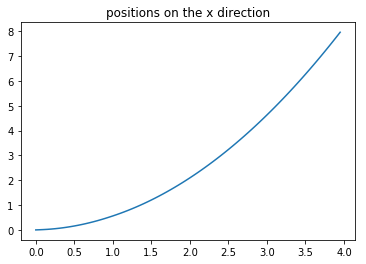

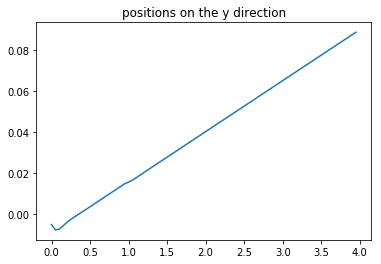

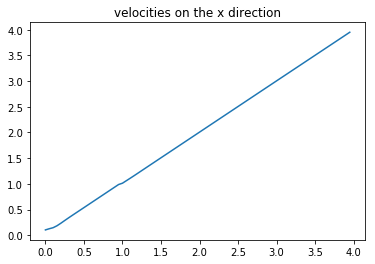

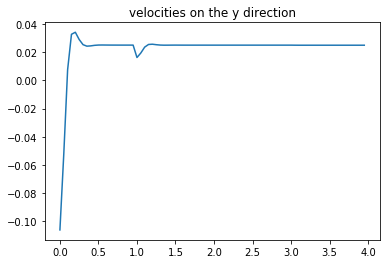

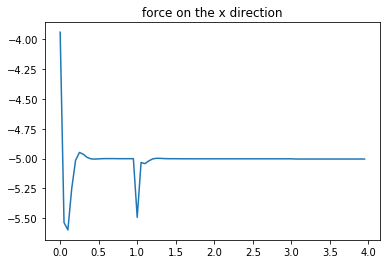

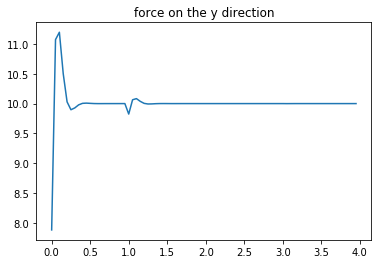

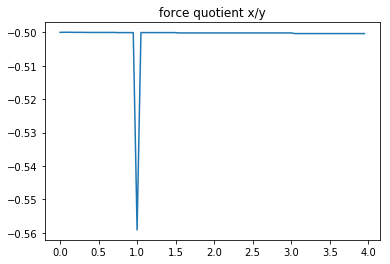

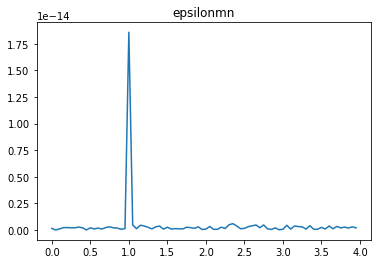

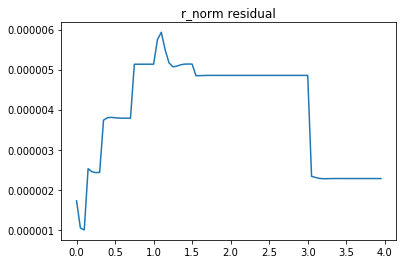

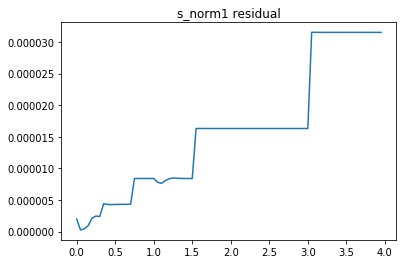

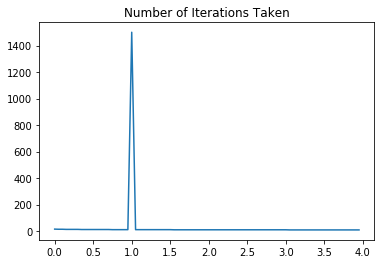

x force at time end:
-0.25019689484
y force at time end:
0.499999998773
velovity at time 3 [ 3.00436799  0.02494905]
R [ 0.0004  0.4   ]
-0.50003152721
9.0
0
0.5
lowest displacement on y:  -0.00792275801139


In [81]:
dropping_particle(4,0.05, 0, np.array([0,0]), np.array([0, 0]), True)

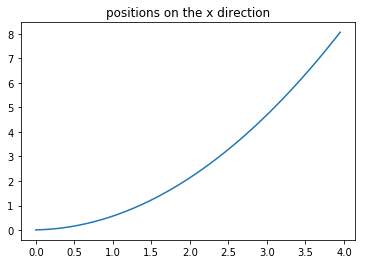

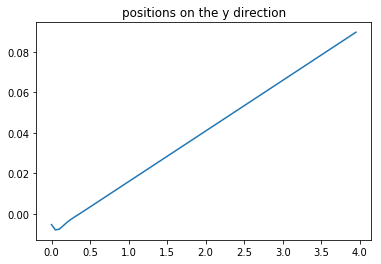

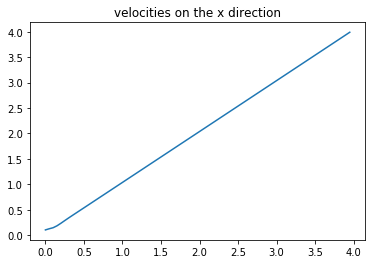

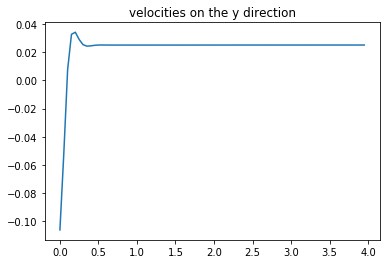

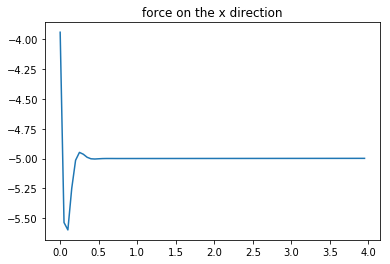

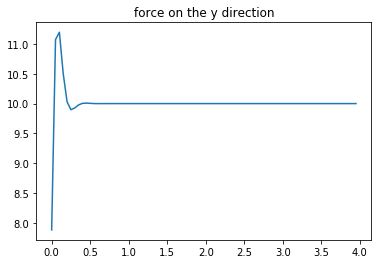

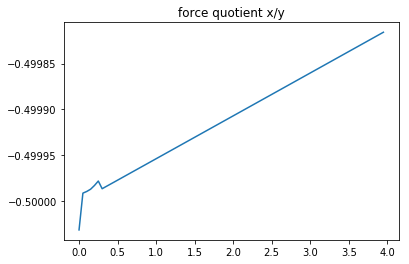

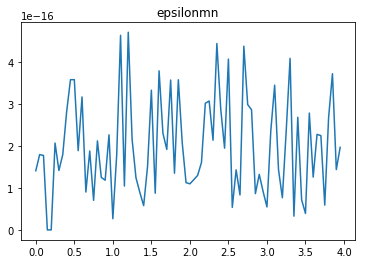

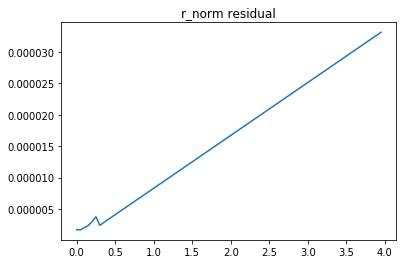

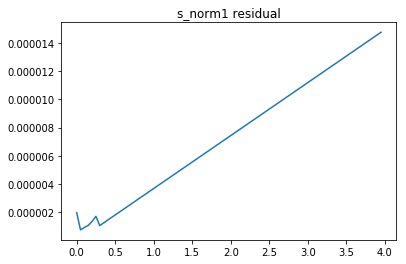

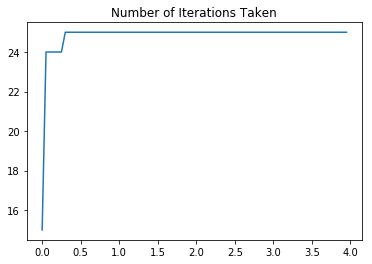

x force at time end:
-0.249912831787
y force at time end:
0.500000585552
velovity at time 3 [ 3.03961364  0.02503433]
R [ 0.0004  0.4   ]
-0.50003152721
25.0
0
0.5
lowest displacement on y:  -0.00792280275548


In [57]:
dropping_particle(4,0.05, 0, np.array([0,0]), np.array([0, 0]))

In [ ]:
starting forces: [[ -8.93871858e+03   2.08500098e+04]
 [  5.27735602e+01   4.62262044e+03]
 [  3.92826107e+02   2.08568303e+03]
 [  3.59958369e+02   9.44083864e+02]
 [  2.52212857e+02   4.30362049e+02]
 [  1.57244110e+02   1.99180049e+02]
 [  9.12631778e+01   9.51418173e+01]
 [  4.99473594e+01   4.83202145e+01]
 [  2.55419925e+01   2.72477389e+01]
 [  1.16523841e+01   1.77634978e+01]
 [  3.94815912e+00   1.34946634e+01]
 [ -2.45854005e-01   1.15731742e+01]
 [ -2.49680055e+00   1.07082245e+01]
 [ -3.69159099e+00   1.03188471e+01]
 [ -4.32020185e+00   1.01435476e+01]
 [ -4.64856615e+00   1.00646209e+01]
 [ -4.81908086e+00   1.00290820e+01]
 [ -4.90719099e+00   1.00130782e+01]
 [ -4.95253140e+00   1.00058705e+01]
 [ -4.97578081e+00   1.00026241e+01]]

In [ ]:
    t = np.arange(0, time, dt)    
    plt.plot(t, positions_record[:, 0])
    plt.title('positions on the x direction')
    plt.show()
    figure()
    t = np.arange(0, time, dt)    
    plt.plot(t, positions_record[:, 1])
    plt.title('positions on the y direction')
    plt.show()
    figure()
    plt.plot(t, velocities_record[:, 0])
    plt.title('velocities on the x direction')
    plt.show()
    figure()
    plt.plot(t, velocities_record[:, 1])
    plt.title('velocities on the y direction')
    plt.show()
    figure()
    plt.plot(t, force_record[:, 0]/dt)
    plt.title('force on the x direction')
    plt.show()
    figure()
    plt.plot(t, force_record[:, 1]/dt)
    plt.title('force on the y direction')
    plt.show()
    figure()
    plt.plot(t, force_record[:, 0]/force_record[:, 1])
    plt.title('force quotient x/y')
    plt.show()
    figure()
    plt.plot(t, epsilon_record)
    plt.title('epsilonmn')
    plt.show()
    figure()
    plt.plot(t, r_norm_record)
    plt.title('r_norm residual')
    plt.show()
    figure()
    plt.plot(t, s_norm1_record)
    plt.title('s_norm1 residual')
    plt.show()
    figure()
    plt.plot(t, num_iters)
    plt.title('Number of Iterations Taken')
    plt.show()
    #print(velocities_record[0, 1])
    print('x force at time end:')
    print(force_record[-5, 0])
    print('y force at time end:')
    print(force_record[-5,1])
    print('velovity at time 3', velocities_record[int(3/dt)])
    print('R', R)
    print(force_record[0,0]/force_record[0,1])
    print(num_iters[-2])
    print(tau_d)
    print(mu)
    print('lowest displacement on y: ', np.amin(positions_record[:, 1]) )

starting r norms: [  1.50463493e+03   2.87503350e+02   1.21059096e+02   5.03189218e+01
   2.05650751e+01   8.21520761e+00   3.17735265e+00   1.17007595e+00
   3.96669167e-01   1.13567069e-01   1.86363726e-02   7.84937868e-03
   1.16509681e-02   9.30283842e-03   6.21653434e-03]
starting s norms: [  2.40600148e+02   1.89127081e+01   1.14853639e+01   6.65601572e+00
   3.73915853e+00   2.05467718e+00   1.11067491e+00   5.92860919e-01
   3.13327522e-01   1.64273393e-01   8.55640975e-02   4.43259536e-02
   2.28585394e-02   1.17426840e-02   6.01258764e-03]

reason for many iterations at the end: initialization of sigma is problematic. If change back to zeros then only 12 iterations (half the value). More specifically the scaling 1/R makes the value 1/R(J*v - vhat) blow up 
If D = R then the convergence rate is much slower. One observation is that the increment of utilda as very low norm (level of e-6) because of the scaling from R so with bad initialization of sigma, things converge very slowly
Another observation is that epsilon_m^n is always within machine epsilon
Through some calculations I have actually shown that the momentum equation is always satisfied. So it can also be used as a criterion to see whether or not our algorithm is doing the right thing

Conclusion: everything is correct. We should think about initialization for sigma and also scaling factor

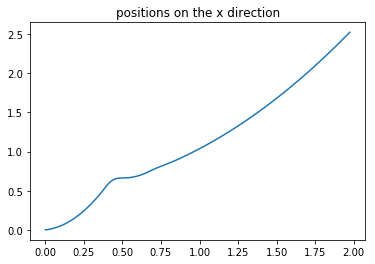

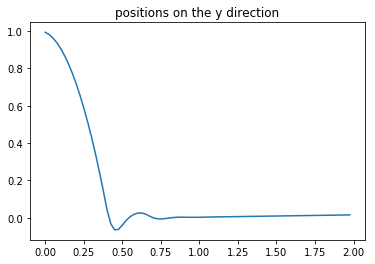

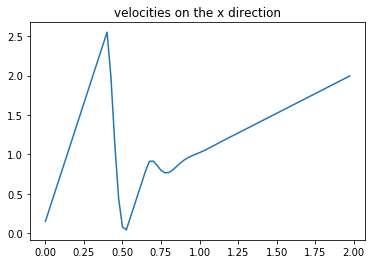

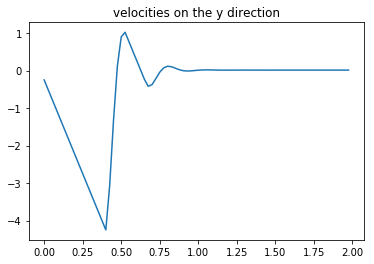

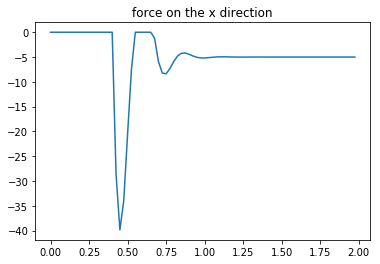

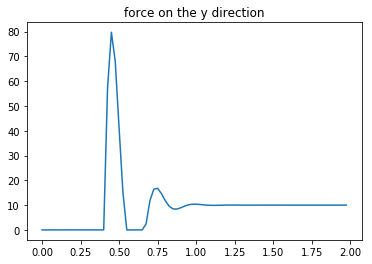

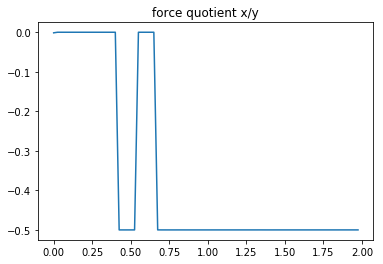

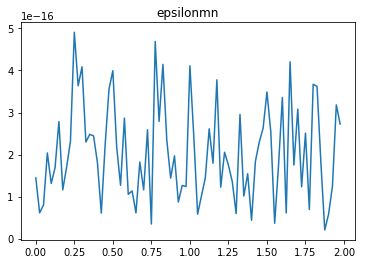

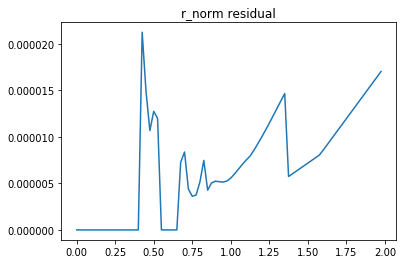

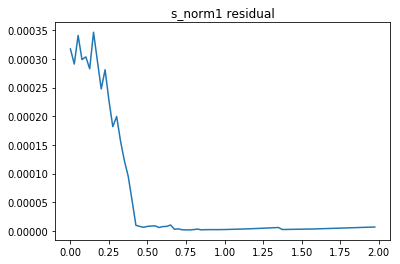

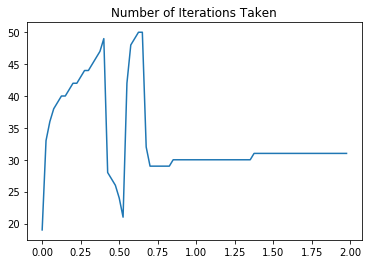

x force at time 0:
-2.90014952719e-07
y force at time 0:
0.000198478174822
-0.00146119316635
31.0
0
0.5
lowest displacement on y:  -0.0654817469248


In [46]:
dropping_particle(2,0.025, 0, np.array([0,1]))

25


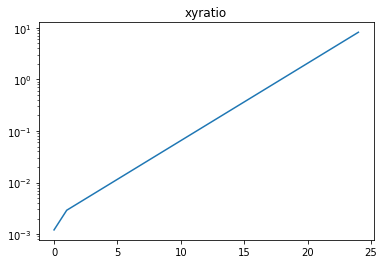

[  1.20433726e-03   2.89953056e-03   4.09698912e-03   5.78897842e-03
   8.17973155e-03   1.15578265e-02   1.63310193e-02   2.30754623e-02
   3.26052498e-02   4.60706831e-02   6.50971195e-02   9.19811620e-02
   1.29967873e-01   1.83642473e-01   2.59483802e-01   3.66646356e-01
   5.18065286e-01   7.32017752e-01   1.03432908e+00   1.46149002e+00
   2.06506142e+00   2.91789791e+00   4.12294189e+00   5.82564926e+00
   8.23154685e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]


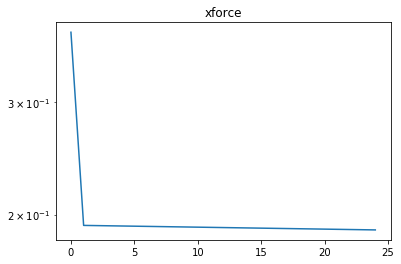

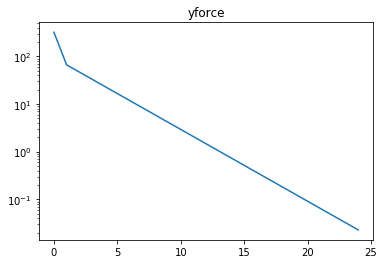

force final
[-0.18929423  0.02299619]
velocity starts dropping at time
0.0


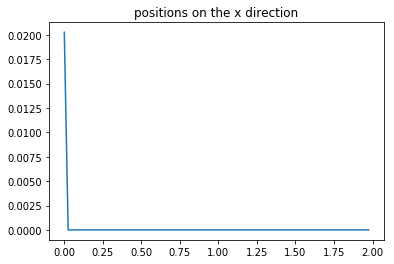

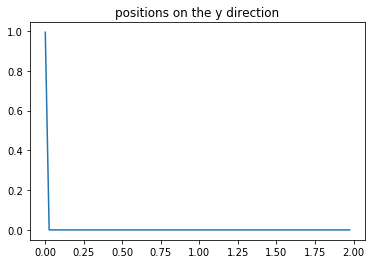

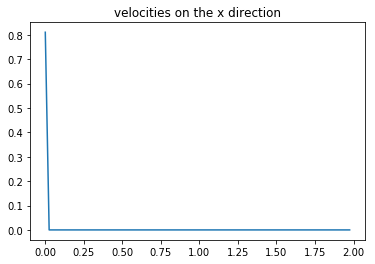

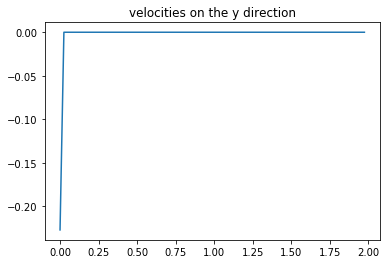

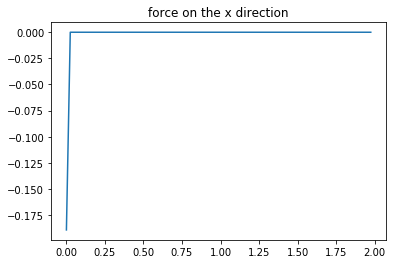

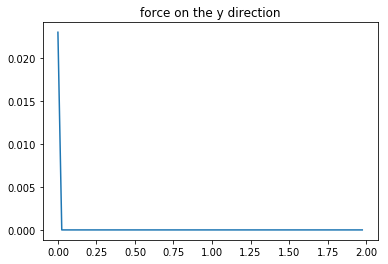

/usr/lib/python3/dist-packages/ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in true_divide


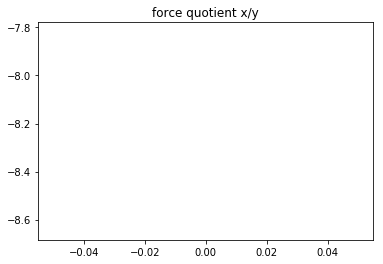

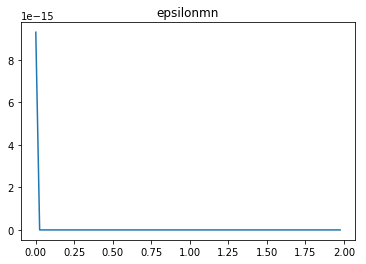

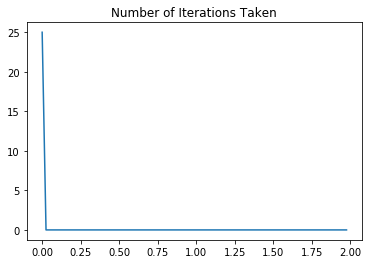

x force at time 0:
-0.189294233254
y force at time 0:
0.0229961921806
-8.23154684774
0.0
0.0316227766017
0.5


In [102]:
dropping_particle(2,0.025,1/(np.sqrt(1000)), np.array([0,1]), np.array([1,0]), True)

xyratio:
0.415118033551
mu
0.5
velocity starts dropping at time
0.0
xyratio:
0.358577912892
mu
0.5
xyratio:
0.267611923527
mu
0.5
xyratio:
0.202725443215
mu
0.5
xyratio:
0.159182822539
mu
0.5
xyratio:
0.127446188829
mu
0.5
xyratio:
0.102824756148
mu
0.5
xyratio:
0.0830180135017
mu
0.5
xyratio:
0.0669401925106
mu
0.5
xyratio:
0.0538983280913
mu
0.5
xyratio:
0.0433544850724
mu
0.5
xyratio:
0.0348542054724
mu
0.5
xyratio:
0.0278982853917
mu
0.5
xyratio:
0.0224189485149
mu
0.5
xyratio:
0.0180173610289
mu
0.5
xyratio:
0.0144812459318
mu
0.5
xyratio:
0.0115224725456
mu
0.5
xyratio:
0.00926575013437
mu
0.5
xyratio:
0.00745753718543
mu
0.5
xyratio:
0.00600642762619
mu
0.5
xyratio:
0.00472144893331
mu
0.5
xyratio:
0.0038092708861
mu
0.5
xyratio:
0.00308137069263
mu
0.5
xyratio:
0.00249808727511
mu
0.5
xyratio:
0.00203141265578
mu
0.5
xyratio:
0.00153911981272
mu
0.5
xyratio:
0.00126077952169
mu
0.5
xyratio:
0.00103993577704
mu
0.5
xyratio:
0.000377127443976
mu
0.5
velocity drop to 0 at time
1.4

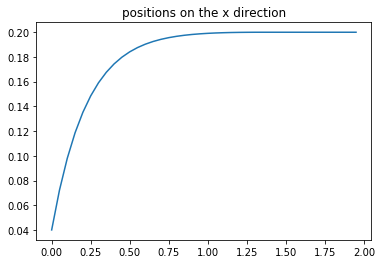

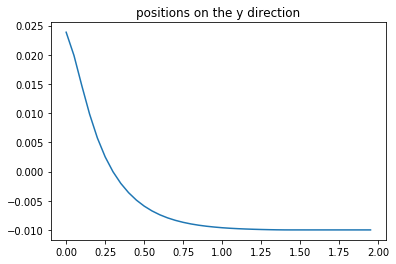

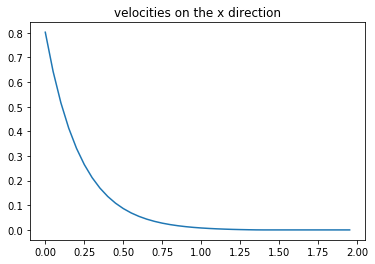

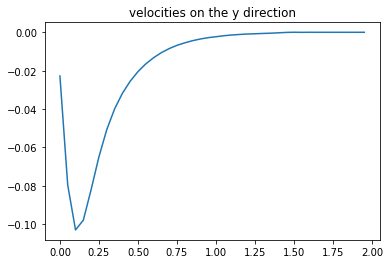

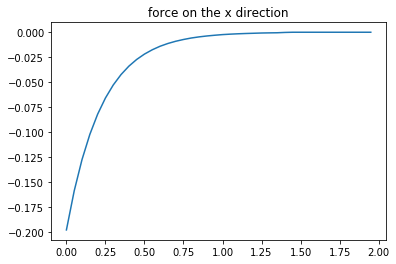

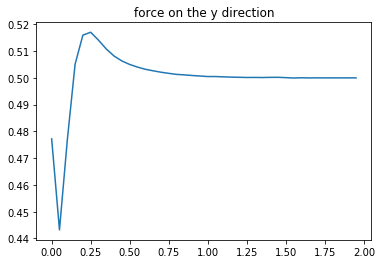

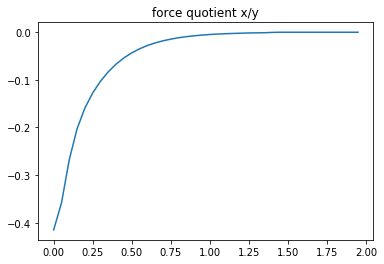

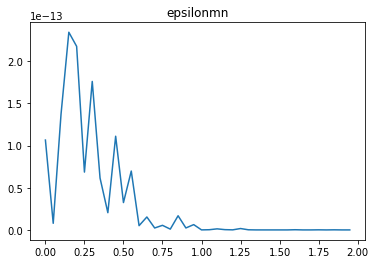

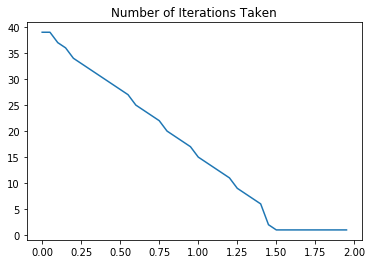

x force at time 0:
-0.1981008586
y force at time 0:
0.477215737668
-0.415118033551
1.0
0.0316227766017
0.5


In [41]:
dropping_particle(2,0.05,1/(np.sqrt(1000)), np.array([0,0.025]), np.array([1,0]))

xyratio:
0.0
mu
0.5
velocity drop to 0 at time
0.0
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:


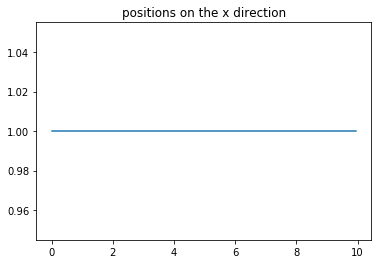

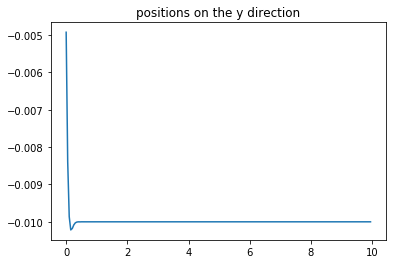

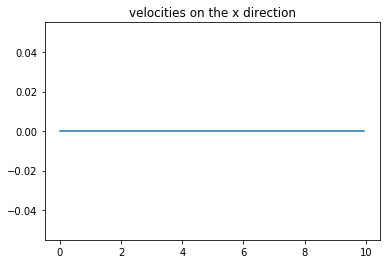

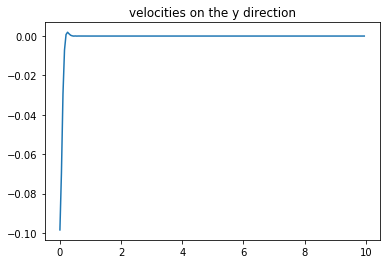

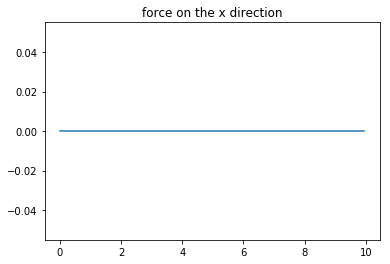

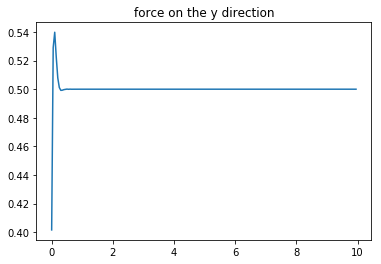

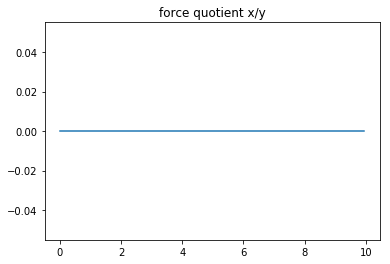

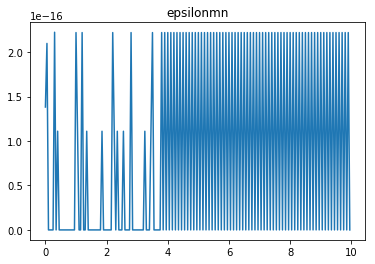

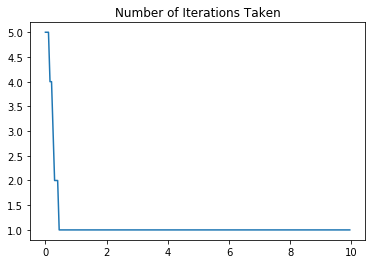

x force at time 0:
0.0
y force at time 0:
0.401548572134
0.0
1.0
0.0316227766017
0.5


In [42]:
dropping_particle(10,0.05,1/(np.sqrt(1000)))

velocity drop to 0 at time
0.0


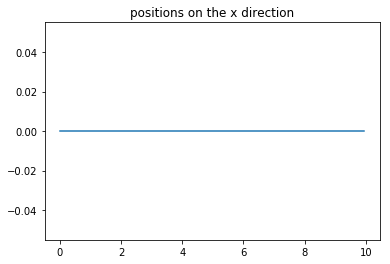

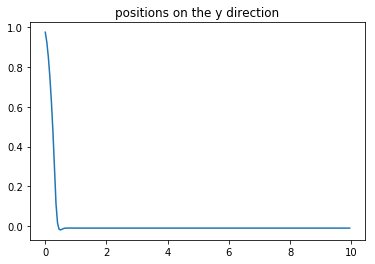

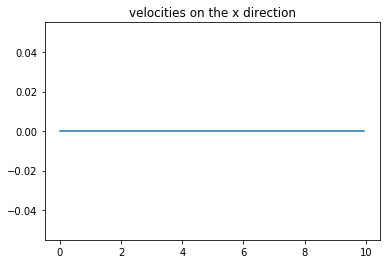

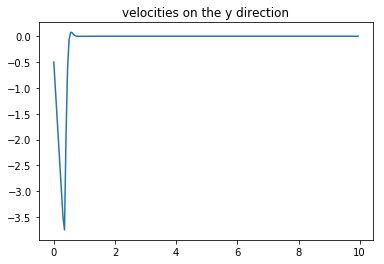

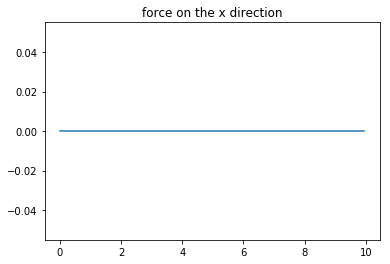

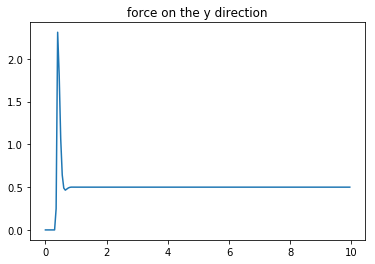

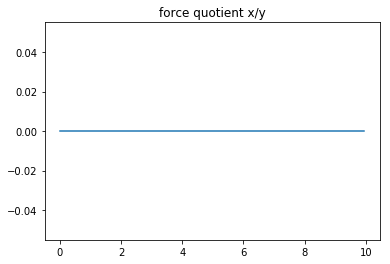

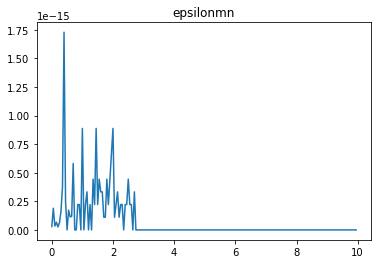

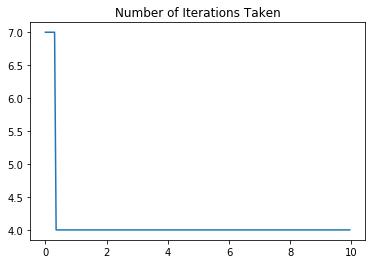

4.0
0.0316227766017
0.5


In [58]:
dropping_particle(10,0.05,1/(np.sqrt(1000)), np.array([0,1]), np.array([0,0]))

In [49]:
#2d projection test:

#t = np.linspace(-5,5, 0.1)
x = np.array([1,0])
v = projection_2D(x, 0.5)
print(v)


[ 0.2  0.4]


In [2]:
import numpy as np
print(1/np.identity(2))

[[  1.  inf]
 [ inf   1.]]


/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


In [7]:
print(diag(np.identity(2)))

[ 1.  1.]
